In [1]:
#  Copyright 2022 Institute of Advanced Research in Artificial Intelligence (IARAI) GmbH.
#  IARAI licenses this file to You under the Apache License, Version 2.0
#  (the "License"); you may not use this file except in compliance with
#  the License. You may obtain a copy of the License at
#  http://www.apache.org/licenses/LICENSE-2.0
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

In [2]:
import os
import sys

In [3]:
# Alternatevly, in order to make the module imports work properly set PYTHONPATH=$PWD before launching the notebook server from the repo root folder.
sys.path.insert(0, os.path.abspath("../"))  # noqa:E402

![t4c20logo](../t4c20logo.png)

In [4]:
import os

import numpy as np
from IPython.core.display import HTML

from IPython.display import display

from t4c22.misc.t4c22_logging import t4c_apply_basic_logging_config
from t4c22.plotting.plot_congestion_classification import plot_segment_classifications_simple
from t4c22.t4c22_config import class_fractions
from t4c22.metric.masked_crossentropy import get_weights_from_class_fractions
from t4c22.misc.parquet_helpers import load_df_from_parquet
import torch
import pandas as pd
from pathlib import Path

In [5]:
%matplotlib inline
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60

display(HTML("<style>.container { width:80% !important; }</style>"))

The time module is not an IPython extension.


Autosaving every 60 seconds


In [6]:
t4c_apply_basic_logging_config(loglevel="INFO")

In [7]:
# load BASEDIR from file, change to your data root
# basedir = load_basedir(fn="t4c22_config.json", pkg=t4c22)
# or use
basedir = Path("your path")

In [8]:
city = "london"
# city = "melbourne"
# city = "madrid"

In [9]:
# TODO search sample locations for other cities?

## Load

In [10]:
day = "2019-07-07"
city = "london"

In [11]:
df_edges = load_df_from_parquet(basedir / "road_graph" / city / "road_graph_edges.parquet")
df_edges

,u,v,parsed_maxspeed,speed_kph,importance,highway,oneway,lanes,tunnel,length_meters,...,node_id_u,counter_info_u,num_assigned_u,x_u,y_u,node_id_v,counter_info_v,num_assigned_v,x_v,y_v
0,78112,25508583,32.2,32.2,0,unclassified,False,,,19.402386,...,78112,,,-0.145792,51.526976,25508583,,,-0.145783,51.526802
1,78112,25508584,32.2,32.2,0,unclassified,False,,,63.881347,...,78112,,,-0.145792,51.526976,25508584,,,-0.145807,51.527550
2,78112,3257621681005534125,32.2,32.2,0,residential,True,,,82.385612,...,78112,,,-0.145792,51.526976,3257621681005534125,,,-0.145514,51.527545
3,99936,2146383887,32.2,32.2,0,unclassified,False,,,8.076410,...,99936,,,-0.152791,51.523611,2146383887,,,-0.152679,51.523630
4,99936,4544836433,32.2,32.2,0,unclassified,True,,,46.803240,...,99936,,,-0.152791,51.523611,4544836433,01/284,1,-0.152916,51.524016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132409,4595139612105786518,8842311879,35.1,35.1,0,residential,False,,,13.486853,...,4595139612105786518,,,-0.299336,51.588589,8842311879,,,-0.299144,51.588568
132410,8230831116681660864,1149426165,35.1,35.1,0,residential,False,,,60.246550,...,8230831116681660864,,,-0.037311,51.680737,1149426165,,,-0.036685,51.680487
132411,1688447984145568529,26559620,32.2,32.2,3,primary,True,2,,4.845324,...,1688447984145568529,,,-0.133773,51.508549,26559620,,,-0.133746,51.508589
132412,3771856370570656347,9402106041,20.0,20.0,0,unclassified,True,,,8.118341,...,3771856370570656347,,,-0.217833,51.549140,9402106041,,,-0.217936,51.549106


In [12]:
df_all_day = df_edges[["u", "v"]]
df_all_day["t"] = [list(range(96))] * len(df_edges)
df_all_day = df_all_day.explode("t")
df_all_day["day"] = day
df_all_day

/tmp/ipykernel_189433/3957670232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_day["t"] = [list(range(96))] * len(df_edges)


,u,v,t,day
0,78112,25508583,0,2019-07-07
0,78112,25508583,1,2019-07-07
0,78112,25508583,2,2019-07-07
0,78112,25508583,3,2019-07-07
0,78112,25508583,4,2019-07-07
...,...,...,...,...
132413,4890701424133264627,27596189,91,2019-07-07
132413,4890701424133264627,27596189,92,2019-07-07
132413,4890701424133264627,27596189,93,2019-07-07
132413,4890701424133264627,27596189,94,2019-07-07


In [13]:
assert len(df_all_day) == 96 * len(df_edges), (len(df_all_day), 96 * len(df_edges))

In [14]:
gt_day = load_df_from_parquet(basedir / f"train/{city}/labels/cc_labels_{day}.parquet")
gt_day

,u,v,day,t,cc
0,78112,25508583,2019-07-07,7,2
1,78112,25508583,2019-07-07,32,1
2,78112,25508583,2019-07-07,35,1
3,78112,25508583,2019-07-07,49,1
4,78112,25508583,2019-07-07,52,1
...,...,...,...,...,...
1987523,4890701424133264627,27596189,2019-07-07,77,1
1987524,4890701424133264627,27596189,2019-07-07,79,1
1987525,4890701424133264627,27596189,2019-07-07,80,1
1987526,4890701424133264627,27596189,2019-07-07,92,1


In [15]:
gt_merged = df_all_day.merge(gt_day, left_on=["u", "v", "t"], right_on=["u", "v", "t"], suffixes=["", "__"], how="left")
assert len(gt_merged) == len(df_all_day)
gt_merged["cc"] = gt_merged["cc"].fillna(0)
gt_merged

,u,v,t,day,day__,cc
0,78112,25508583,0,2019-07-07,NaN,0.0
1,78112,25508583,1,2019-07-07,NaN,0.0
2,78112,25508583,2,2019-07-07,NaN,0.0
3,78112,25508583,3,2019-07-07,NaN,0.0
4,78112,25508583,4,2019-07-07,NaN,0.0
...,...,...,...,...,...,...
12711739,4890701424133264627,27596189,91,2019-07-07,NaN,0.0
12711740,4890701424133264627,27596189,92,2019-07-07,2019-07-07,1.0
12711741,4890701424133264627,27596189,93,2019-07-07,NaN,0.0
12711742,4890701424133264627,27596189,94,2019-07-07,NaN,0.0


In [16]:
# TODO take those from all data
df_congestion_classes_distribution_hour = load_df_from_parquet(
    basedir / "congestion_classes_distribution" / city / "congestion_classes_distribution_hour_all_week.parquet"
).reset_index()
df_congestion_classes_distribution_hour

cc,u,v,h,1,2,3,total,proba_green,proba_yellow,proba_red
0,78112,25508583,0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000
1,78112,25508583,1,3.0,4.0,0.0,7.0,0.428571,0.571429,0.000000
2,78112,25508583,2,0.0,3.0,0.0,3.0,0.000000,1.000000,0.000000
3,78112,25508583,3,5.0,3.0,2.0,10.0,0.500000,0.300000,0.200000
4,78112,25508583,4,2.0,12.0,1.0,15.0,0.133333,0.800000,0.066667
...,...,...,...,...,...,...,...,...,...,...
3095343,9206673423374839908,2329125548,19,302.0,7.0,0.0,309.0,0.977346,0.022654,0.000000
3095344,9206673423374839908,2329125548,20,252.0,8.0,0.0,260.0,0.969231,0.030769,0.000000
3095345,9206673423374839908,2329125548,21,204.0,6.0,2.0,212.0,0.962264,0.028302,0.009434
3095346,9206673423374839908,2329125548,22,174.0,13.0,6.0,193.0,0.901554,0.067358,0.031088


In [17]:
df_h_t = pd.DataFrame.from_dict([{"h": h, "t": h * 4 + t} for h in range(24) for t in range(4)])
df_h_t

,h,t
0,0,0
1,0,1
2,0,2
3,0,3
4,1,4
...,...,...
91,22,91
92,23,92
93,23,93
94,23,94


In [18]:
# expand...
df_congestion_classes_distribution_hour = df_congestion_classes_distribution_hour.merge(df_h_t, on="h", how="left")
df_congestion_classes_distribution_hour

,u,v,h,1,2,3,total,proba_green,proba_yellow,proba_red,t
0,78112,25508583,0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,0
1,78112,25508583,0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,1
2,78112,25508583,0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,2
3,78112,25508583,0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,3
4,78112,25508583,1,3.0,4.0,0.0,7.0,0.428571,0.571429,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...
12381387,9206673423374839908,2329125548,22,174.0,13.0,6.0,193.0,0.901554,0.067358,0.031088,91
12381388,9206673423374839908,2329125548,23,147.0,3.0,0.0,150.0,0.980000,0.020000,0.000000,92
12381389,9206673423374839908,2329125548,23,147.0,3.0,0.0,150.0,0.980000,0.020000,0.000000,93
12381390,9206673423374839908,2329125548,23,147.0,3.0,0.0,150.0,0.980000,0.020000,0.000000,94


In [20]:
df_congestion_classes_distribution_hour["cc"] = (
    # TODO may be misleading in case of ties.
    np.argmax(
        [
            df_congestion_classes_distribution_hour["proba_green"],
            df_congestion_classes_distribution_hour["proba_yellow"],
            df_congestion_classes_distribution_hour["proba_red"],
        ],
        axis=0,
    )
    + 1
)
df_congestion_classes_distribution_hour

,u,v,h,1,2,3,total,proba_green,proba_yellow,proba_red,t,cc
0,78112,25508583,0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,0,1
1,78112,25508583,0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,1,1
2,78112,25508583,0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,2,1
3,78112,25508583,0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,3,1
4,78112,25508583,1,3.0,4.0,0.0,7.0,0.428571,0.571429,0.000000,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
12381387,9206673423374839908,2329125548,22,174.0,13.0,6.0,193.0,0.901554,0.067358,0.031088,91,1
12381388,9206673423374839908,2329125548,23,147.0,3.0,0.0,150.0,0.980000,0.020000,0.000000,92,1
12381389,9206673423374839908,2329125548,23,147.0,3.0,0.0,150.0,0.980000,0.020000,0.000000,93,1
12381390,9206673423374839908,2329125548,23,147.0,3.0,0.0,150.0,0.980000,0.020000,0.000000,94,1


In [21]:
gt_merged = gt_merged.merge(df_congestion_classes_distribution_hour, left_on=["u", "v", "t"], right_on=["u", "v", "t"], suffixes=["_true", "_pred"], how="left")
gt_merged

,u,v,t,day,day__,cc_true,h,1,2,3,total,proba_green,proba_yellow,proba_red,cc_pred
0,78112,25508583,0,2019-07-07,NaN,0.0,0.0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,1.0
1,78112,25508583,1,2019-07-07,NaN,0.0,0.0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,1.0
2,78112,25508583,2,2019-07-07,NaN,0.0,0.0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,1.0
3,78112,25508583,3,2019-07-07,NaN,0.0,0.0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,1.0
4,78112,25508583,4,2019-07-07,NaN,0.0,1.0,3.0,4.0,0.0,7.0,0.428571,0.571429,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12711739,4890701424133264627,27596189,91,2019-07-07,NaN,0.0,22.0,120.0,59.0,4.0,183.0,0.655738,0.322404,0.021858,1.0
12711740,4890701424133264627,27596189,92,2019-07-07,2019-07-07,1.0,23.0,139.0,48.0,2.0,189.0,0.735450,0.253968,0.010582,1.0
12711741,4890701424133264627,27596189,93,2019-07-07,NaN,0.0,23.0,139.0,48.0,2.0,189.0,0.735450,0.253968,0.010582,1.0
12711742,4890701424133264627,27596189,94,2019-07-07,NaN,0.0,23.0,139.0,48.0,2.0,189.0,0.735450,0.253968,0.010582,1.0


In [22]:
city_class_fractions = class_fractions[city]
city_class_weights = torch.tensor(get_weights_from_class_fractions([city_class_fractions[c] for c in ["green", "yellow", "red"]])).float()
loss_f_weighted = torch.nn.CrossEntropyLoss(weight=city_class_weights, ignore_index=-1, reduction="none")
loss_f_unweighted = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction="none")


# get true labels
y = torch.tensor(gt_merged["cc_true"].to_numpy() - 1)
y = y.nan_to_num(-1)
y = y.long()
print(y.size())
print(y)
print(y.min())
print(y.max())

# get pred logits
y_hat = torch.log(torch.tensor(gt_merged[["proba_green", "proba_yellow", "proba_red"]].to_numpy()).float())
print(y_hat.size())
print(y_hat)
loss = loss_f_weighted(y_hat, y)

gt_merged["loss"] = loss
gt_merged

torch.Size([12711744])
tensor([-1, -1, -1,  ..., -1, -1,  0])
tensor(-1)
tensor(2)
torch.Size([12711744, 3])
tensor([[-0.1823, -1.7918,    -inf],
        [-0.1823, -1.7918,    -inf],
        [-0.1823, -1.7918,    -inf],
        ...,
        [-0.3073, -1.3705, -4.5486],
        [-0.3073, -1.3705, -4.5486],
        [-0.3073, -1.3705, -4.5486]])


,u,v,t,day,day__,cc_true,h,1,2,3,total,proba_green,proba_yellow,proba_red,cc_pred,loss
0,78112,25508583,0,2019-07-07,NaN,0.0,0.0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,1.0,0.000000
1,78112,25508583,1,2019-07-07,NaN,0.0,0.0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,1.0,0.000000
2,78112,25508583,2,2019-07-07,NaN,0.0,0.0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,1.0,0.000000
3,78112,25508583,3,2019-07-07,NaN,0.0,0.0,10.0,2.0,0.0,12.0,0.833333,0.166667,0.000000,1.0,0.000000
4,78112,25508583,4,2019-07-07,NaN,0.0,1.0,3.0,4.0,0.0,7.0,0.428571,0.571429,0.000000,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12711739,4890701424133264627,27596189,91,2019-07-07,NaN,0.0,22.0,120.0,59.0,4.0,183.0,0.655738,0.322404,0.021858,1.0,0.000000
12711740,4890701424133264627,27596189,92,2019-07-07,2019-07-07,1.0,23.0,139.0,48.0,2.0,189.0,0.735450,0.253968,0.010582,1.0,0.190809
12711741,4890701424133264627,27596189,93,2019-07-07,NaN,0.0,23.0,139.0,48.0,2.0,189.0,0.735450,0.253968,0.010582,1.0,0.000000
12711742,4890701424133264627,27596189,94,2019-07-07,NaN,0.0,23.0,139.0,48.0,2.0,189.0,0.735450,0.253968,0.010582,1.0,0.000000


## London bridge, northbound

In [23]:
u = 3240063179
v = 6032044868
df_ = gt_merged[(gt_merged["u"] == u) & (gt_merged["v"] == v)]
df_

,u,v,t,day,day__,cc_true,h,1,2,3,total,proba_green,proba_yellow,proba_red,cc_pred,loss
11256864,3240063179,6032044868,0,2019-07-07,2019-07-07,3.0,0.0,81.0,152.0,127.0,360.0,0.225000,0.422222,0.352778,2.0,3.105692
11256865,3240063179,6032044868,1,2019-07-07,2019-07-07,3.0,0.0,81.0,152.0,127.0,360.0,0.225000,0.422222,0.352778,2.0,3.105692
11256866,3240063179,6032044868,2,2019-07-07,2019-07-07,2.0,0.0,81.0,152.0,127.0,360.0,0.225000,0.422222,0.352778,2.0,0.817939
11256867,3240063179,6032044868,3,2019-07-07,NaN,0.0,0.0,81.0,152.0,127.0,360.0,0.225000,0.422222,0.352778,2.0,0.000000
11256868,3240063179,6032044868,4,2019-07-07,2019-07-07,3.0,1.0,110.0,94.0,66.0,270.0,0.407407,0.348148,0.244444,1.0,4.199181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11256955,3240063179,6032044868,91,2019-07-07,2019-07-07,3.0,22.0,63.0,140.0,151.0,354.0,0.177966,0.395480,0.426554,3.0,2.539649
11256956,3240063179,6032044868,92,2019-07-07,NaN,0.0,23.0,79.0,143.0,129.0,351.0,0.225071,0.407407,0.367521,2.0,0.000000
11256957,3240063179,6032044868,93,2019-07-07,2019-07-07,3.0,23.0,79.0,143.0,129.0,351.0,0.225071,0.407407,0.367521,2.0,2.983651
11256958,3240063179,6032044868,94,2019-07-07,2019-07-07,1.0,23.0,79.0,143.0,129.0,351.0,0.225071,0.407407,0.367521,2.0,0.926083


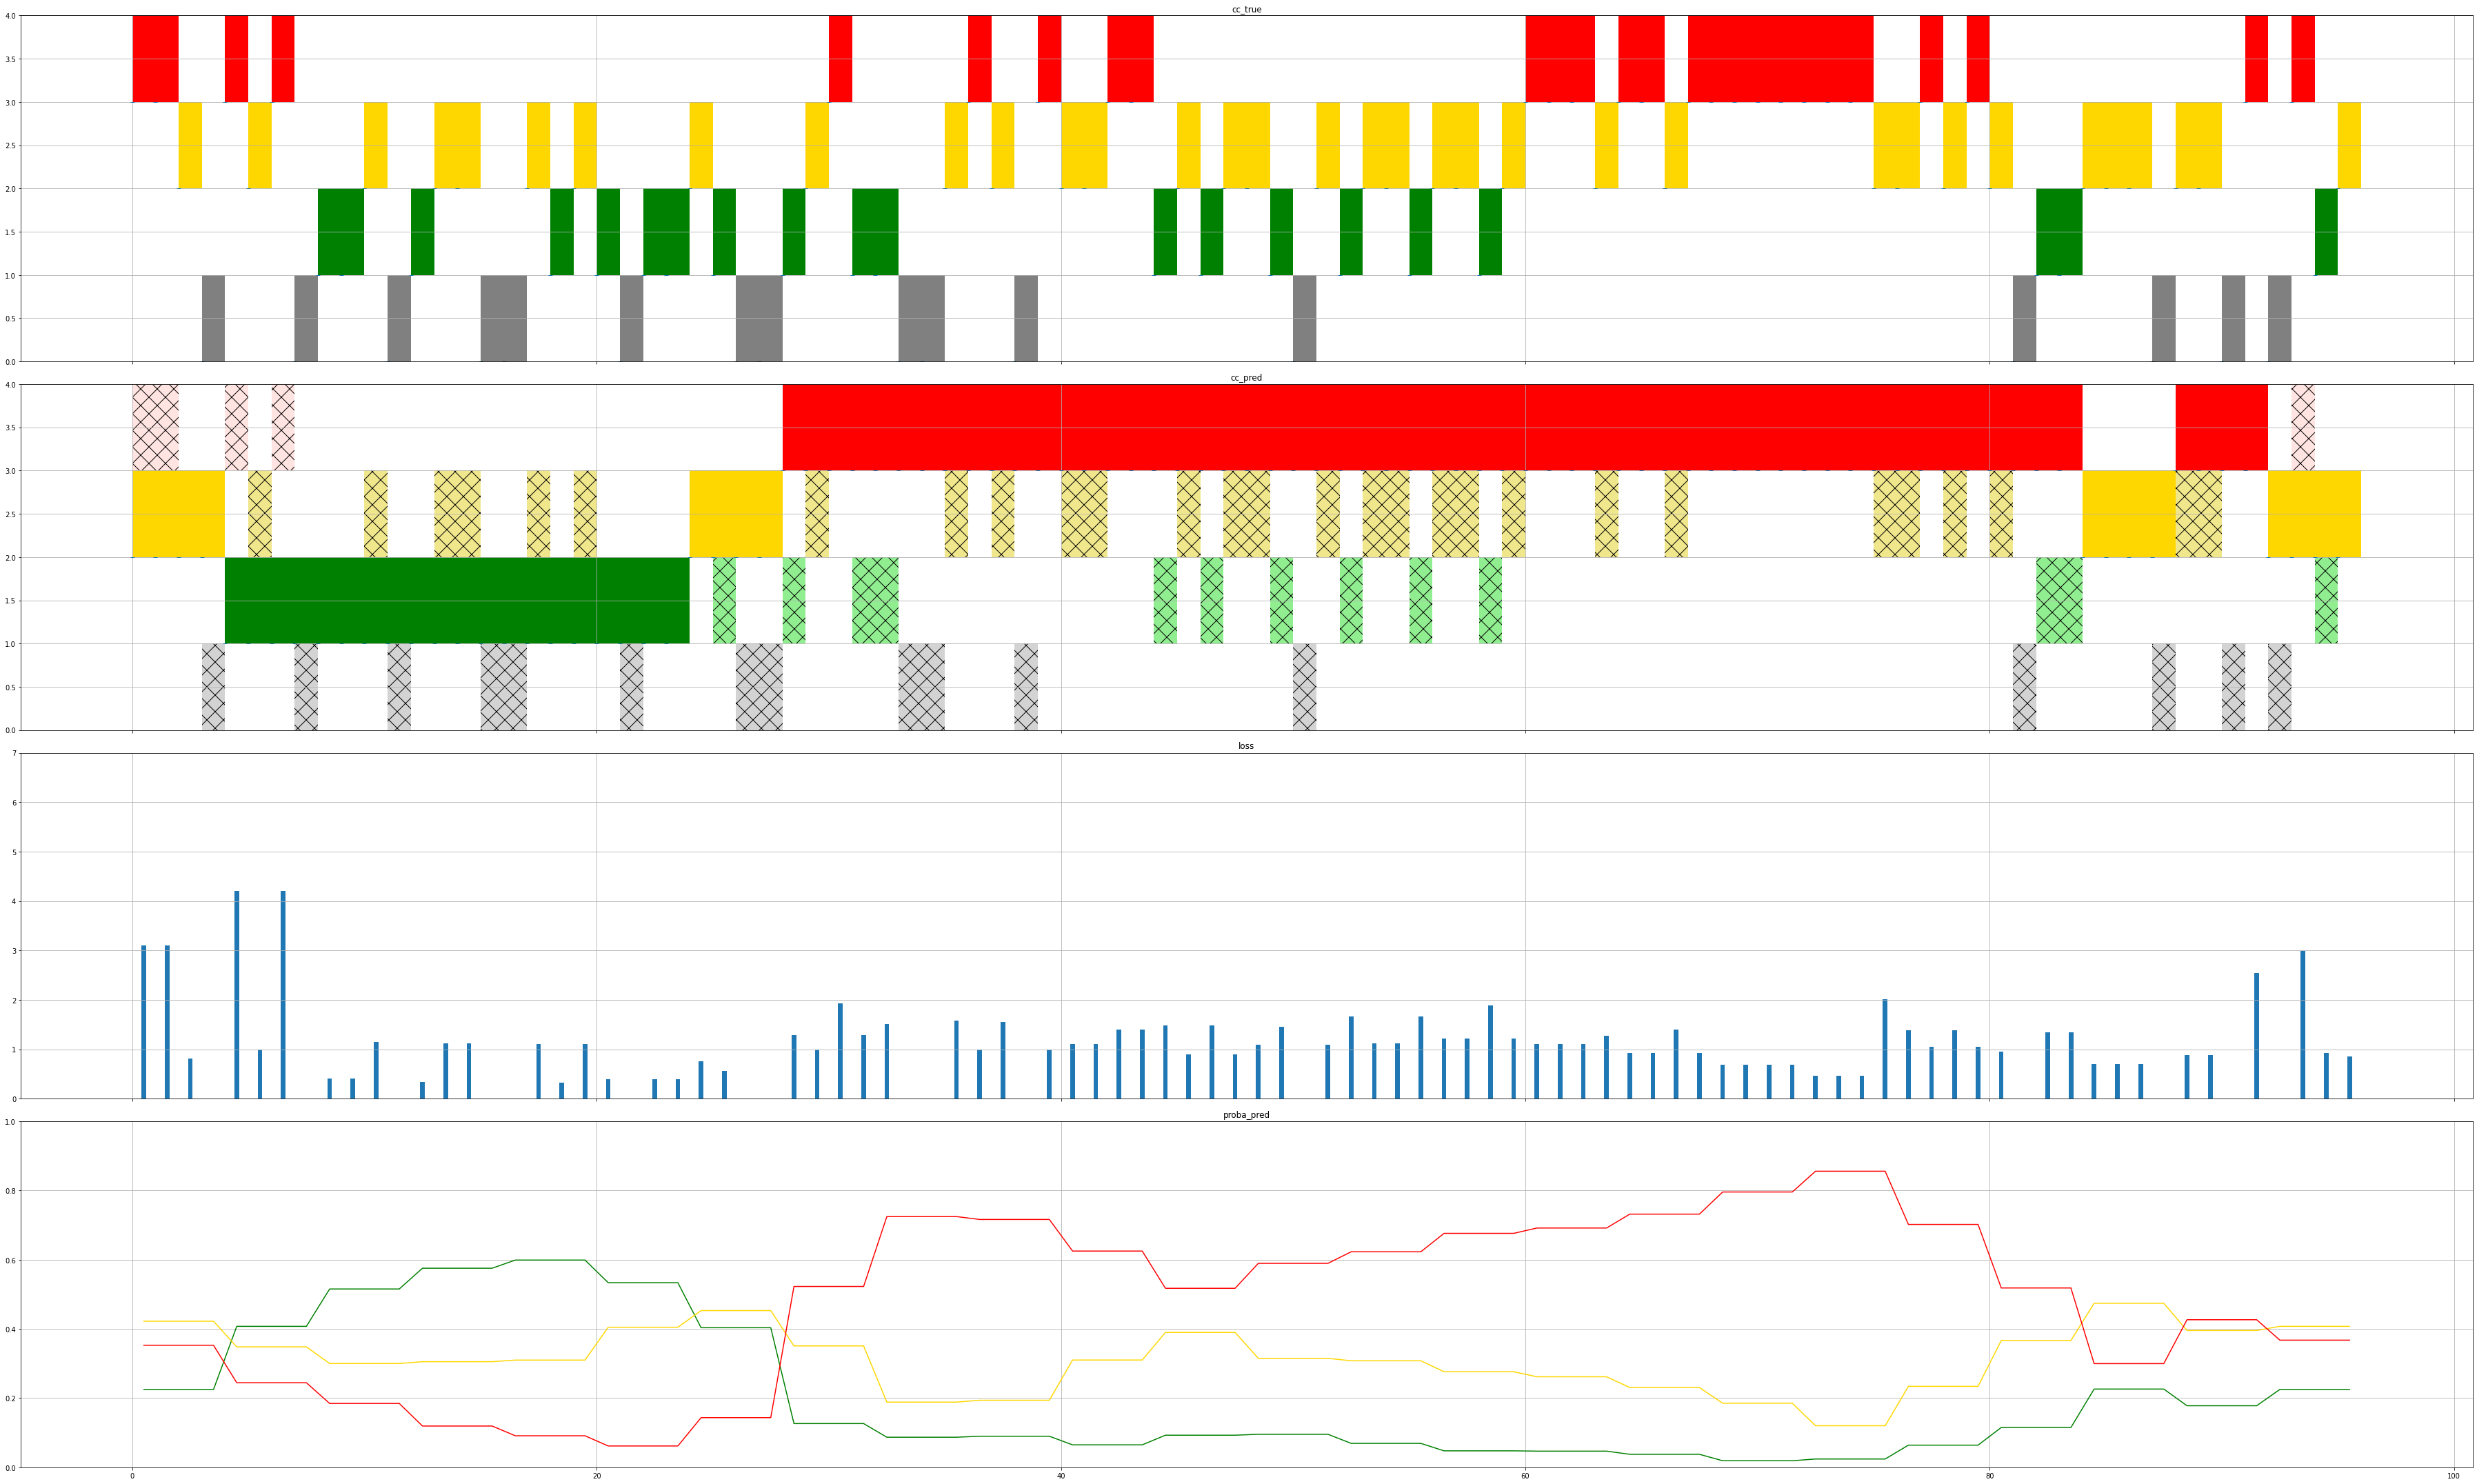

In [24]:
fig, axs = plot_segment_classifications_simple(
    df_["cc_pred"].values,
    df_["cc_true"].values,
    losses=df_["loss"].values,
    proba_green=df_["proba_green"],
    proba_yellow=df_["proba_yellow"],
    proba_red=df_["proba_red"],
)

## Elephant and castle, northbound

In [25]:
u = 2180693488
v = 1868411754
df_ = gt_merged[(gt_merged["u"] == u) & (gt_merged["v"] == v)]

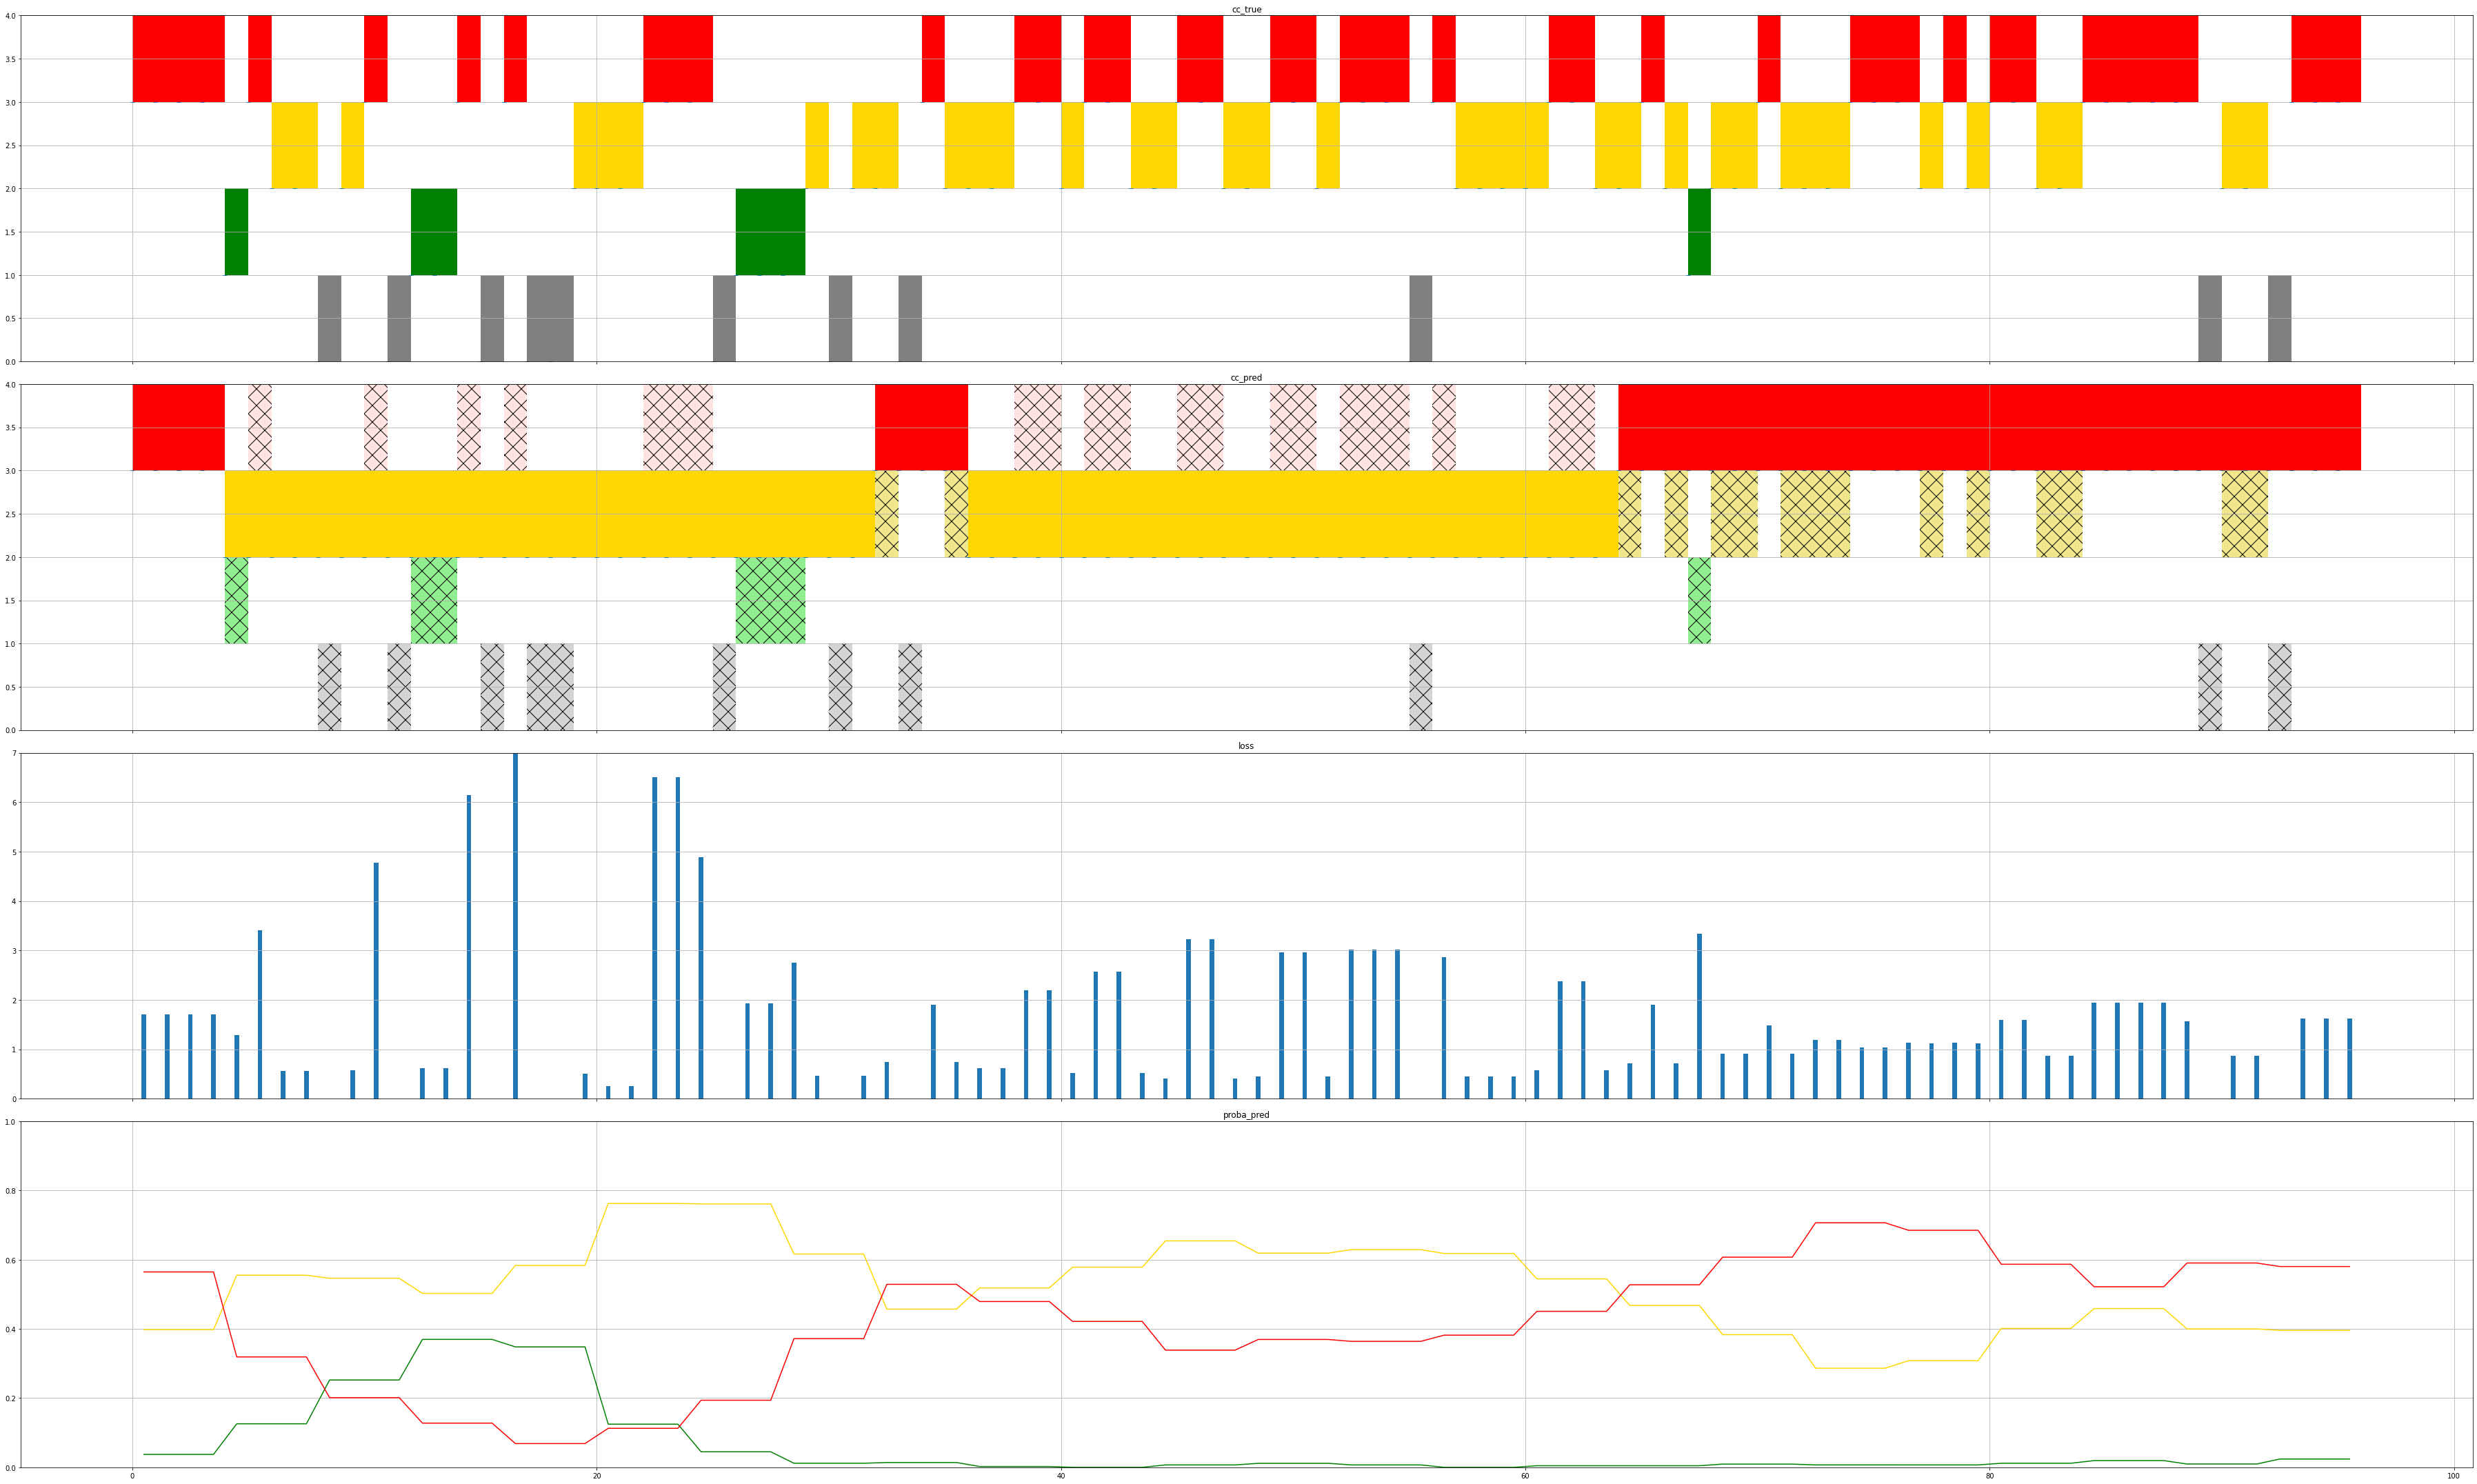

In [26]:
fig, axs = plot_segment_classifications_simple(
    df_["cc_pred"].values,
    df_["cc_true"].values,
    losses=df_["loss"].values,
    proba_green=df_["proba_green"],
    proba_yellow=df_["proba_yellow"],
    proba_red=df_["proba_red"],
)

## Marleybone flyover, eastbound

In [27]:
u = 1178910690
v = 197630

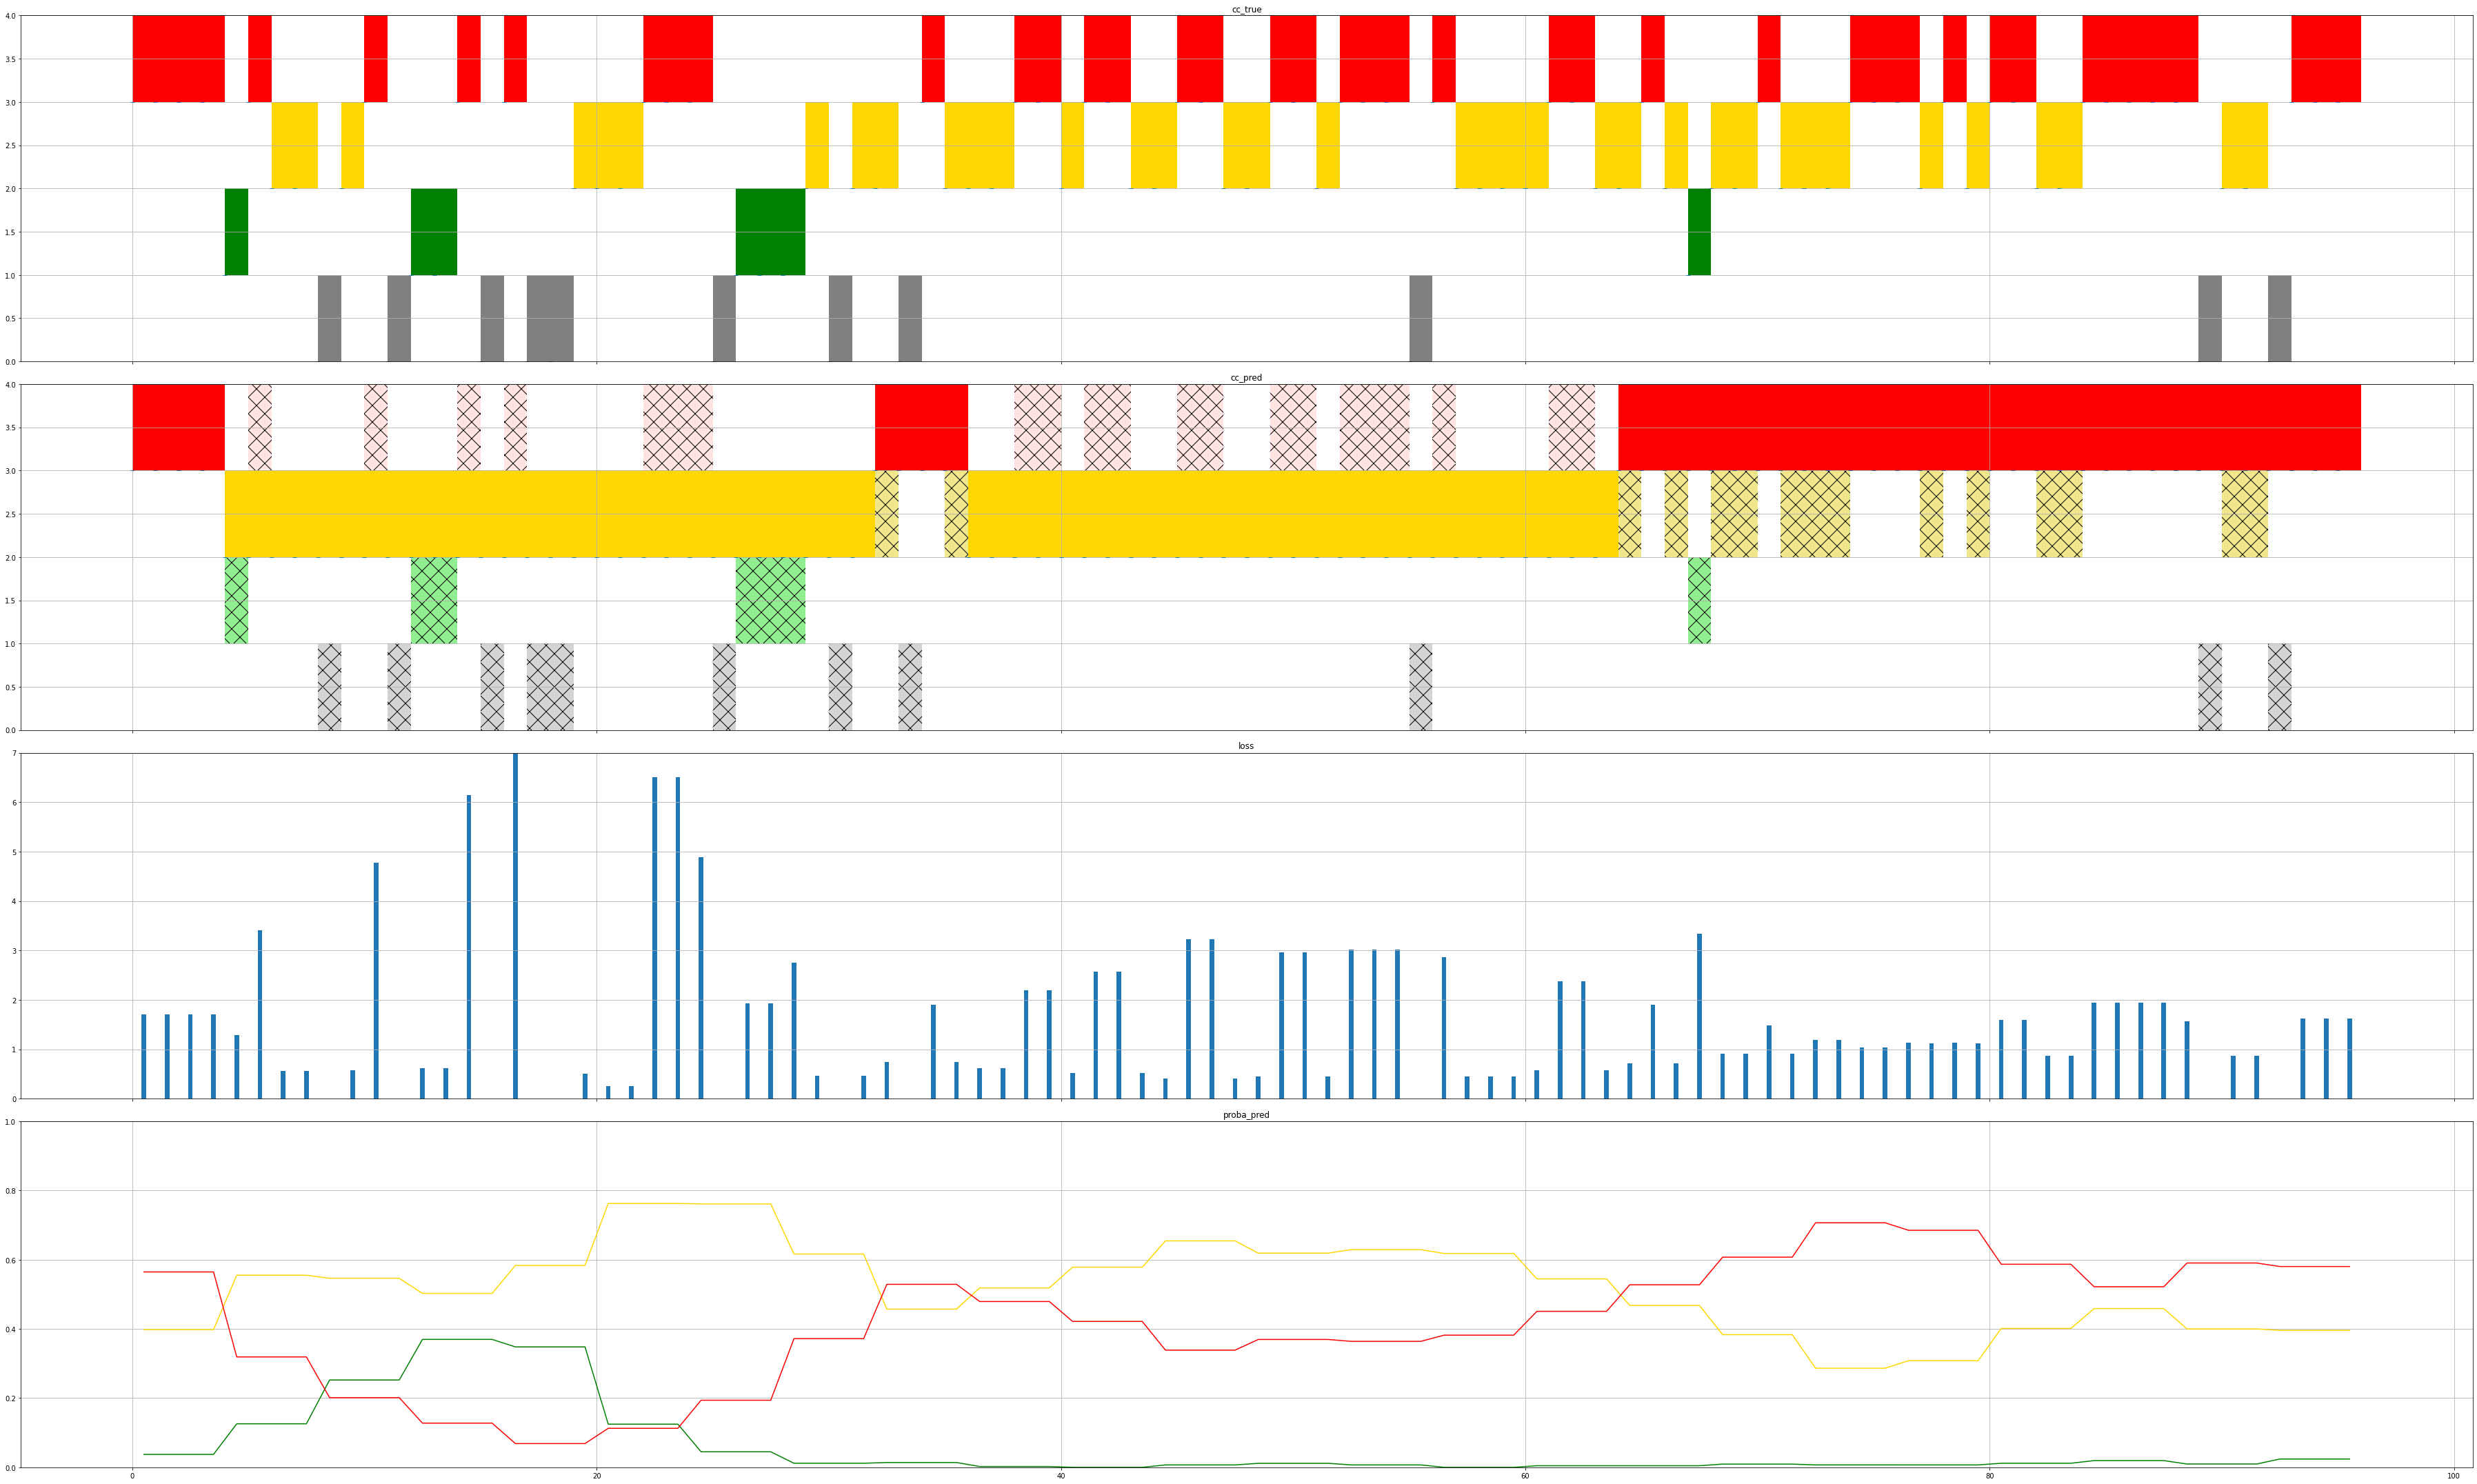

In [28]:
fig, axs = plot_segment_classifications_simple(
    df_["cc_pred"].values,
    df_["cc_true"].values,
    losses=df_["loss"].values,
    proba_green=df_["proba_green"],
    proba_yellow=df_["proba_yellow"],
    proba_red=df_["proba_red"],
)

## M25 near Waltham, eastbound

In [29]:
u = 4737949241782541459
v = 5177230596161574999

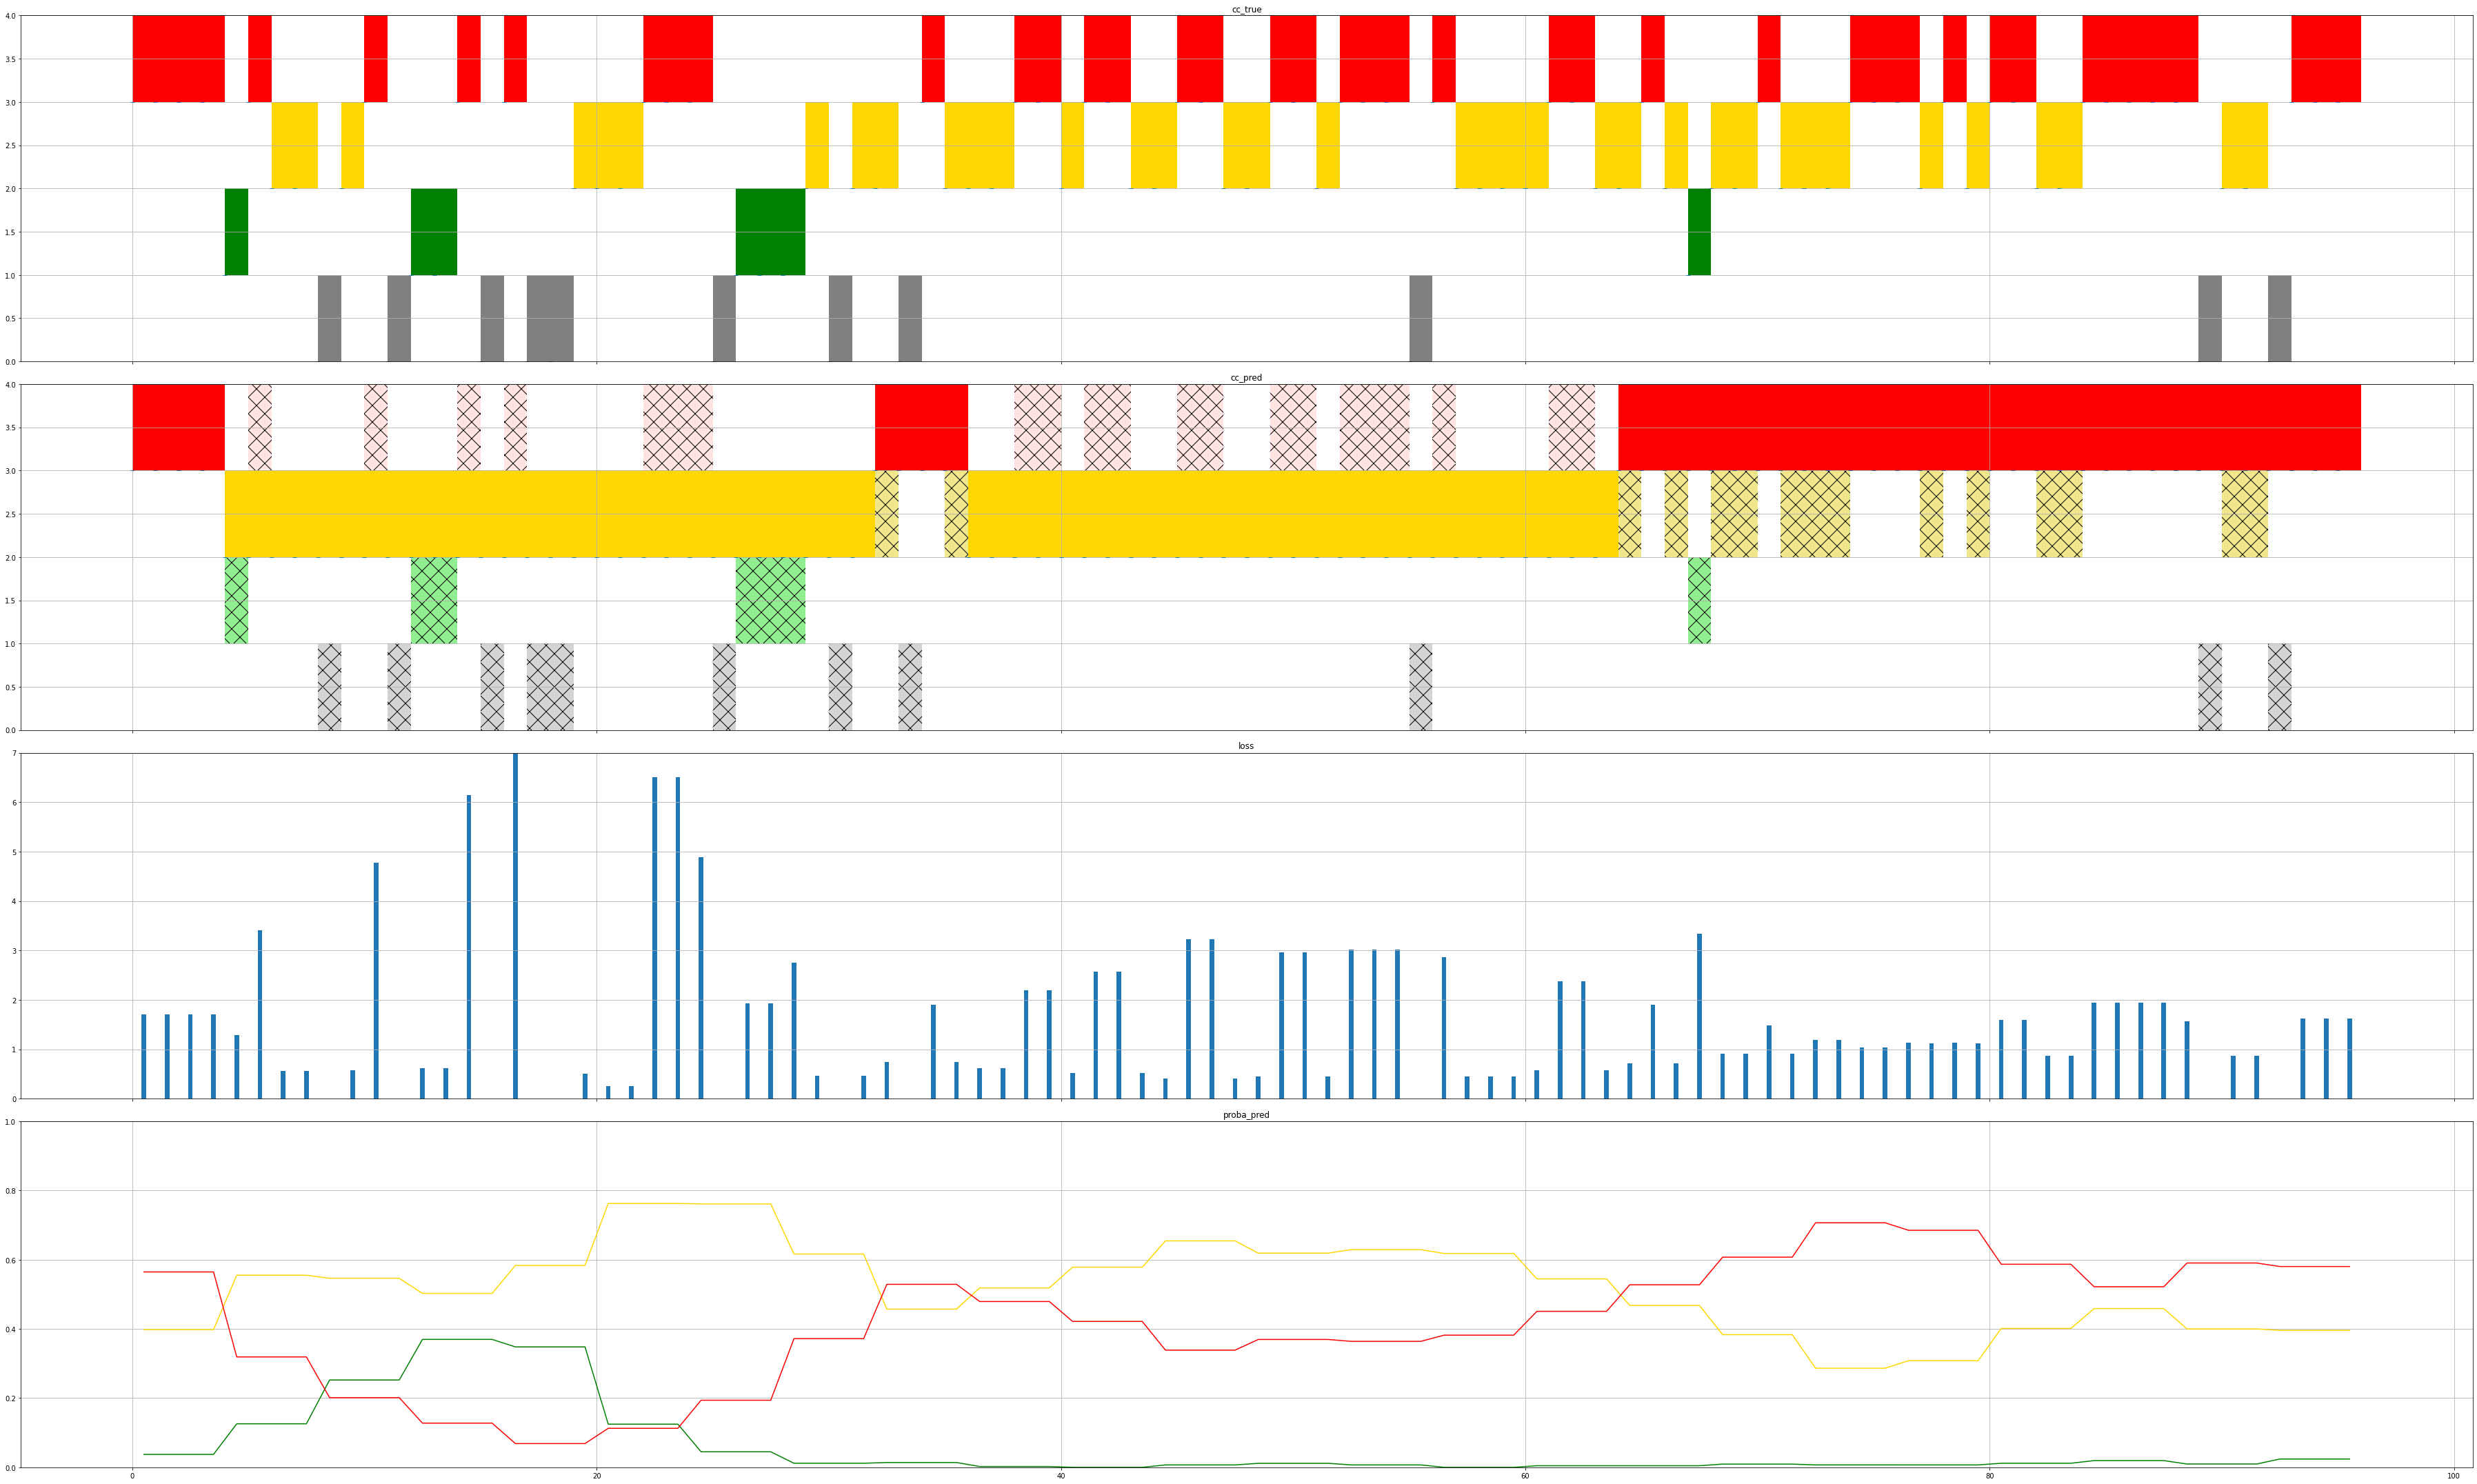

In [30]:
fig, axs = plot_segment_classifications_simple(
    df_["cc_pred"].values,
    df_["cc_true"].values,
    losses=df_["loss"].values,
    proba_green=df_["proba_green"],
    proba_yellow=df_["proba_yellow"],
    proba_red=df_["proba_red"],
)

## M25 near Potters Bar, westbound

In [31]:
u = 8995114026285597218
v = 196709089314436495

## at counter 08/093

In [32]:
u = 2180661925
v = 8953368684960847732

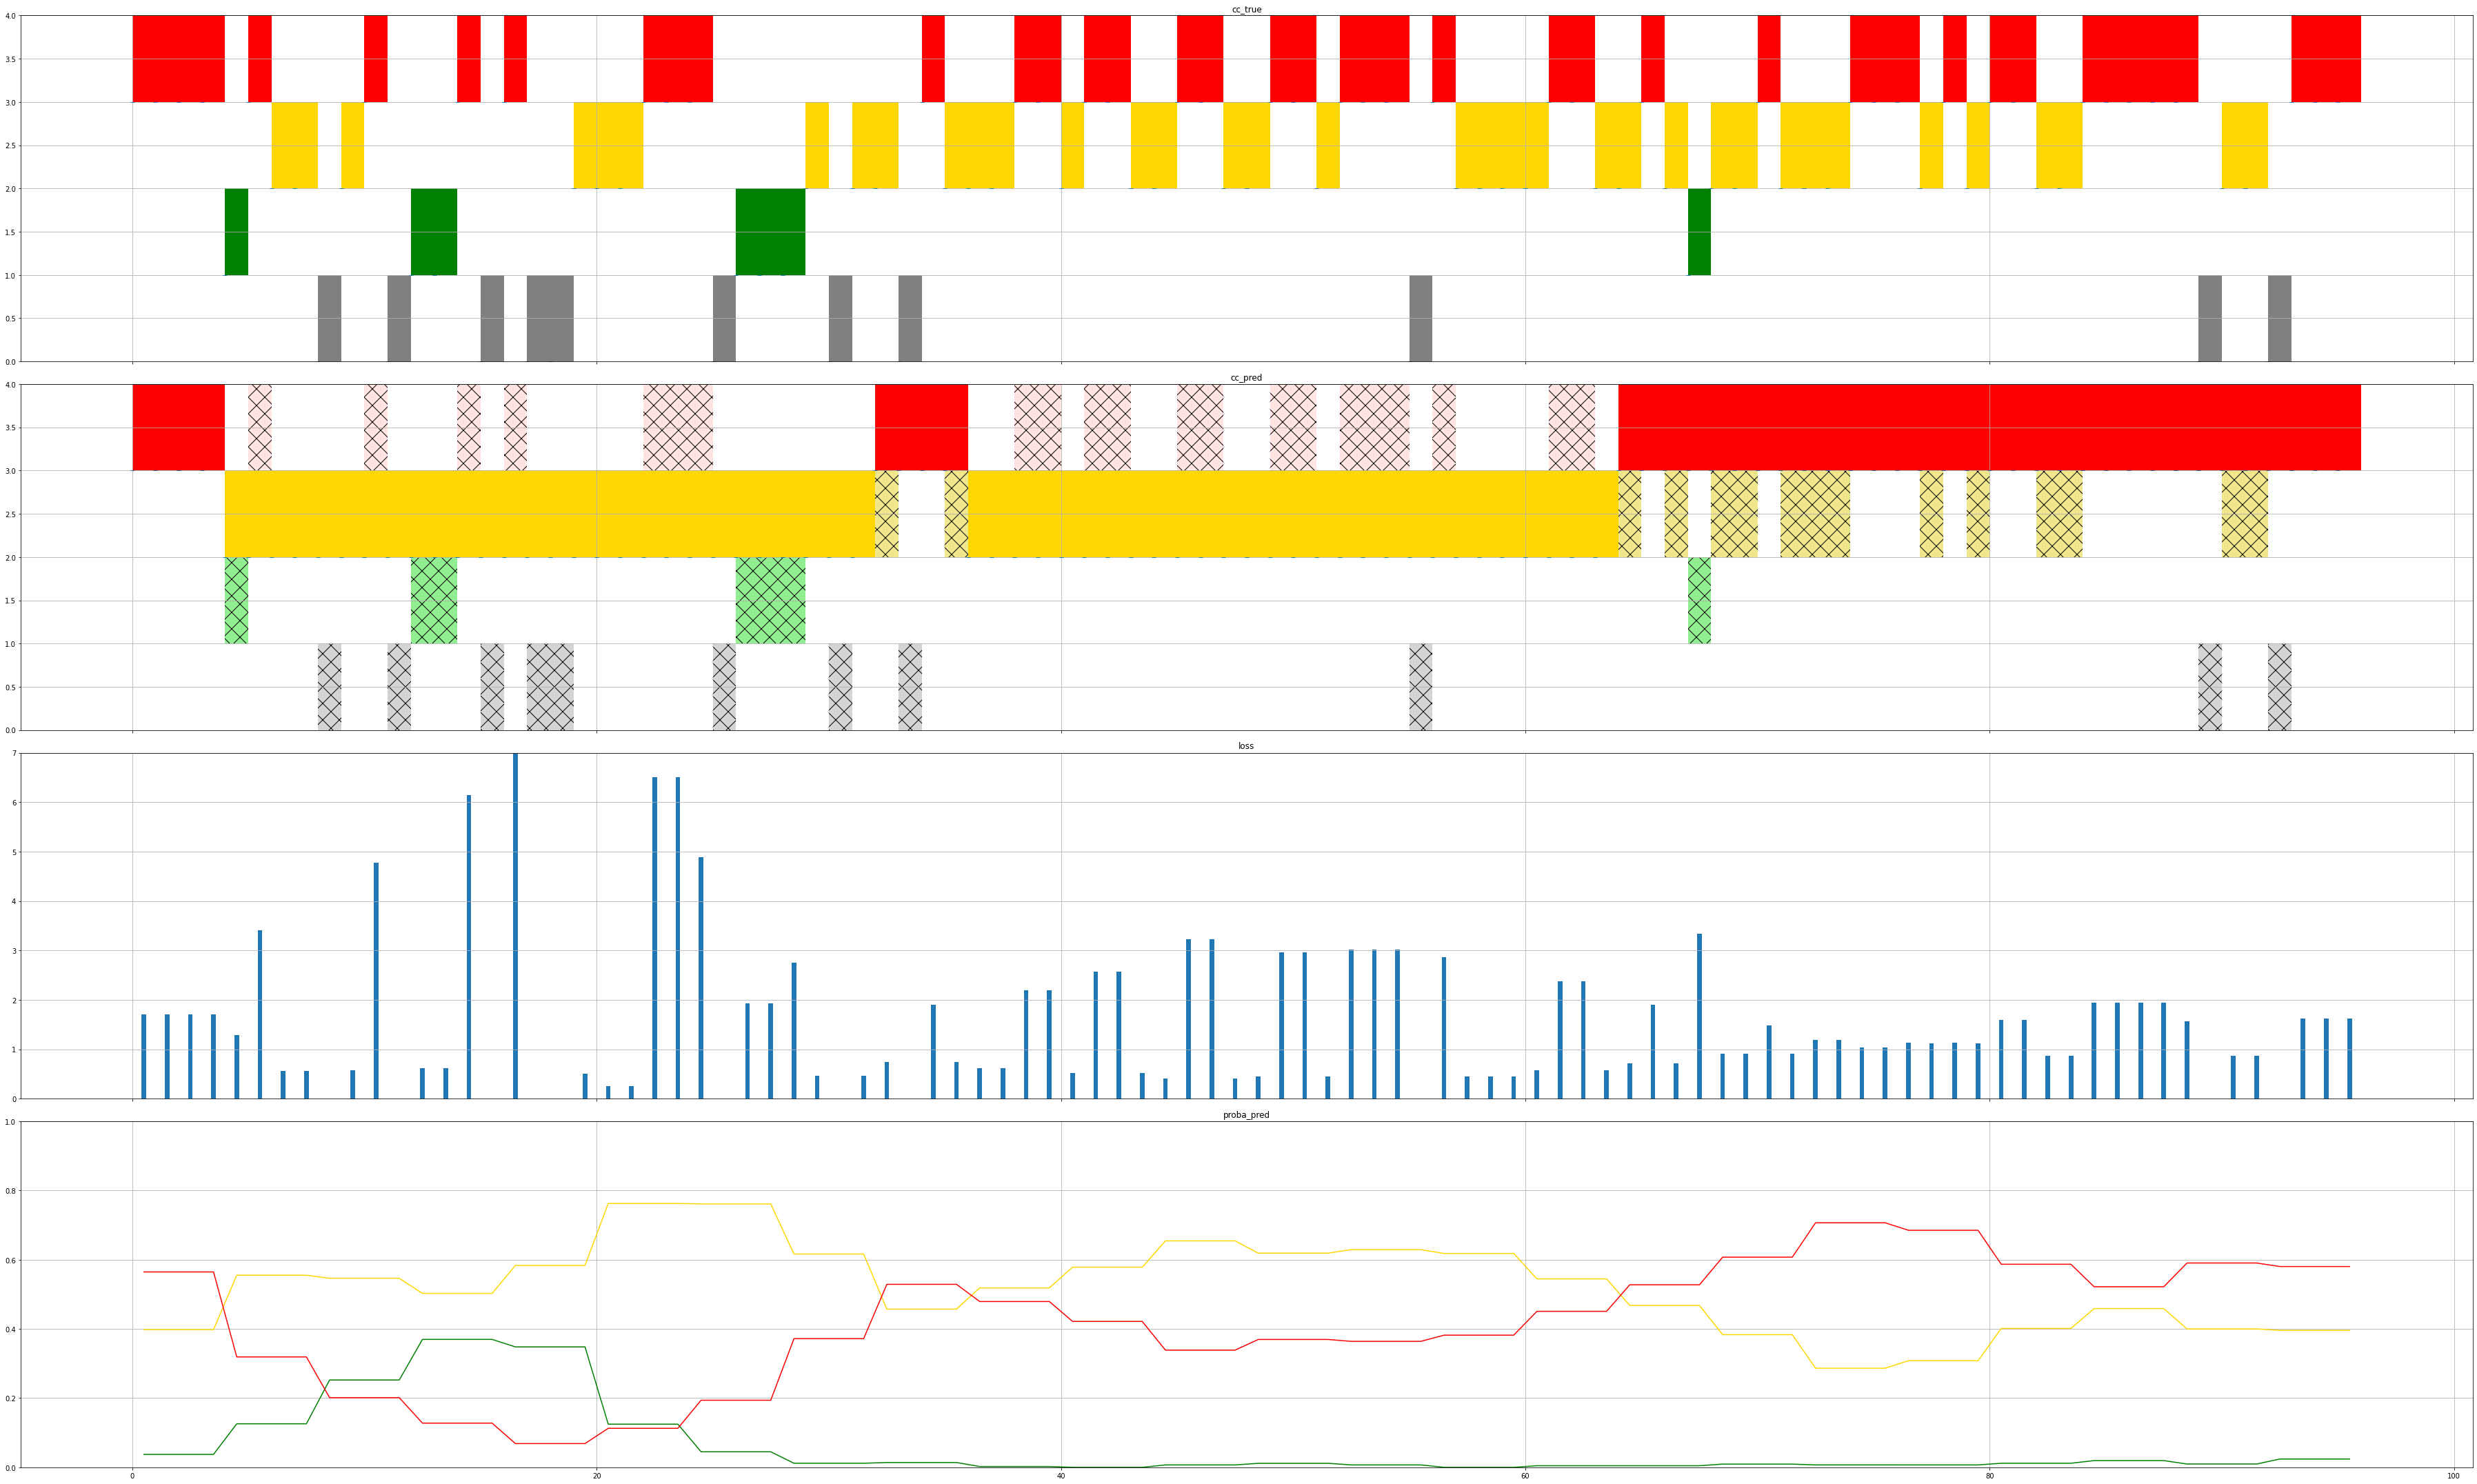

In [33]:
fig, axs = plot_segment_classifications_simple(
    df_["cc_pred"].values,
    df_["cc_true"].values,
    losses=df_["loss"].values,
    proba_green=df_["proba_green"],
    proba_yellow=df_["proba_yellow"],
    proba_red=df_["proba_red"],
)